In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm
import re
from sklearn import preprocessing
import librosa
from imblearn.combine import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
import pywt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

In [2]:
from util import load

df, attachList = load.load(list(range(1, 7 + 1)) + [9])
df

../3rd天府杯A提/附件9\20.txt: 100%|██████████| 160/160 [00:03<00:00, 45.60it/s]


,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,...,9-11,9-12,9-13,9-14,9-15,9-16,9-17,9-18,9-19,9-20
0,0.031847,0.016663,0.020103,0.005837,-0.011276,-0.025771,0.021692,0.009281,0.010529,0.001247,...,0.093444,-0.039594,0.034525,-0.017206,0.037083,0.014242,-0.005727,0.001487,-0.004651,0.000754
1,-0.011189,-0.002048,0.006537,0.023145,0.012113,-0.017351,0.010933,-0.003817,0.004915,-0.007641,...,-0.098345,-0.065790,0.022830,-0.015803,0.024453,0.000677,-0.000582,0.009907,-0.003247,-0.007198
2,-0.019609,-0.007661,-0.002818,0.003030,0.021468,-0.009866,0.007658,-0.004752,0.003980,-0.002028,...,-0.083844,-0.049886,0.032186,-0.002705,0.038019,-0.008679,0.014387,-0.004594,-0.002780,-0.005327
3,0.019685,0.007308,-0.002351,-0.019423,0.004160,-0.003318,0.005787,-0.018318,-0.022216,-0.028223,...,0.122446,0.003441,0.058382,0.015070,0.046439,0.006290,-0.005260,0.001954,-0.003247,0.011045
4,-0.020076,0.001226,-0.020594,0.016596,0.013048,-0.015948,-0.000294,-0.023931,0.003045,-0.024481,...,0.131334,-0.002640,0.060253,0.030507,0.049245,-0.009614,0.004564,0.000083,-0.017748,-0.010472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-2.936200,1.122488,1.303684,-0.291669,-0.145528,0.035976,0.138636,-0.077726,0.077889,-0.176508,...,7.072680,0.896428,0.855474,-0.456449,-0.032148,0.131654,-0.293878,0.063701,0.110423,-1.465260
7996,-3.392283,2.000974,0.883152,-0.199985,0.457904,0.205311,0.186349,-0.010833,0.116246,-0.133005,...,5.946740,-2.363980,0.868572,-0.477967,-0.014840,0.351510,-0.117994,0.176903,0.114165,-1.481632
7997,-2.868840,1.194994,0.248846,0.020338,0.813415,0.481300,0.176526,-0.000075,0.141039,-0.115230,...,3.495588,-5.519137,0.892896,-0.539246,-0.015308,0.576511,0.027017,0.240989,0.117439,-1.503617
7998,-2.935732,-0.888954,-0.528132,0.284164,0.943457,0.712382,0.149862,-0.014108,0.181735,-0.082953,...,0.451293,-7.890768,0.886815,-0.575732,-0.023728,0.787946,0.161269,0.239118,0.108551,-1.546653


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


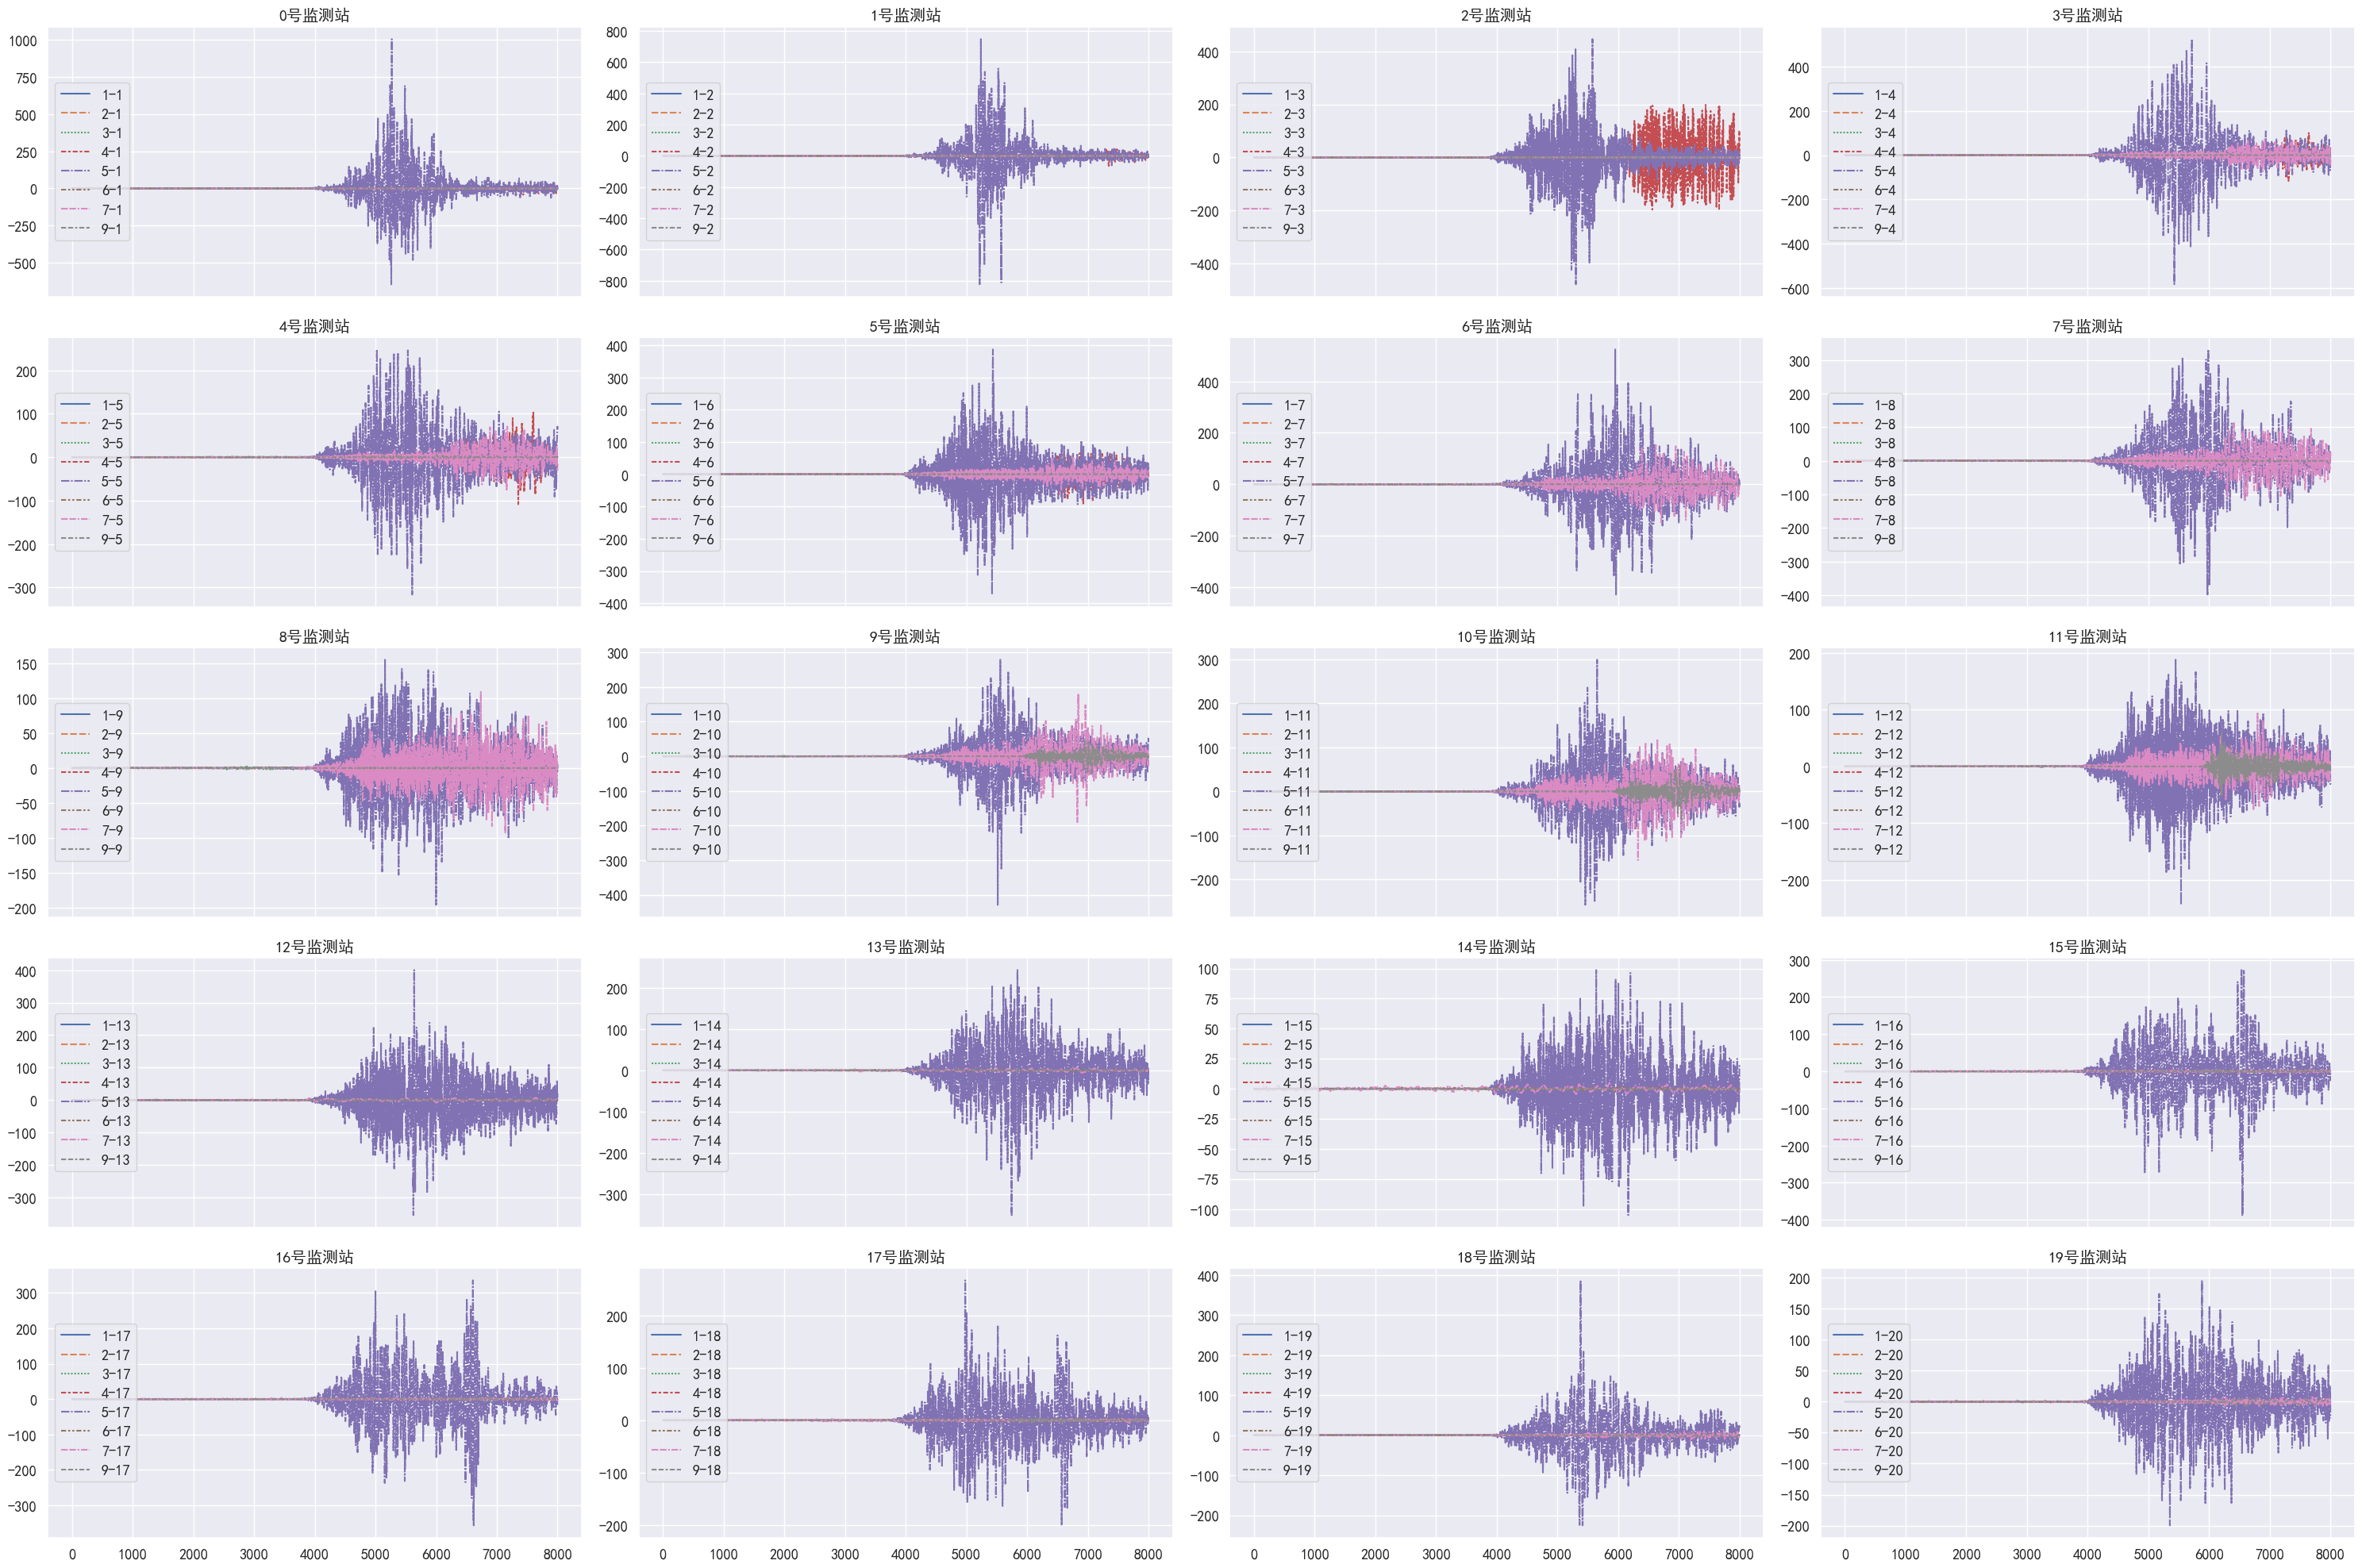

In [46]:
fig, axs = plt.subplots(5, 4, figsize=(30, 20), sharex='all')
cnt = 0
for i in tqdm.tqdm(range(5)):
    for ii in range(4):
        ax = axs[i, ii]
        sns.lineplot(df.iloc[:, cnt::20], ax=ax)
        ax.set_title(f'{cnt}号监测站')
        ax.legend(loc='center left')
        cnt += 1

plt.tight_layout()
plt.show()

In [8]:
def 计算小波(col: str):
    # 1. 获取地震监测加速度信号数据
    # 这里假设你已经有了加速度信号数据，并将其存储在acceleration变量中
    acceleration = df[col]

    # 2. 导入所需的库

    # 3. 设定信号采样频率和时间序列
    sampling_frequency = 200
    time = np.arange(len(acceleration)) / sampling_frequency

    # 4. 执行Morlet小波变换
    wavelet = 'morl'
    scales = np.arange(1, 200)
    coefficients, frequencies = pywt.cwt(acceleration, scales, wavelet)

    # 5. 计算小波系数的模的平方，得到能量
    energy = np.abs(coefficients) ** 2

    return energy, coefficients, frequencies

for 每个监测点 do
    Morlet小波变换
    for 每个小波尺度 do
        if 整个小波尺度数据都是0
            continue
        end
        其他小波尺度的数据都相加求平均
    end
end

In [15]:
energy, coefficients, frequencies = 计算小波('1-1')
frequencies

array([0.8125    , 0.40625   , 0.27083333, 0.203125  , 0.1625    ,
       0.13541667, 0.11607143, 0.1015625 , 0.09027778, 0.08125   ,
       0.07386364, 0.06770833, 0.0625    , 0.05803571, 0.05416667,
       0.05078125, 0.04779412, 0.04513889, 0.04276316, 0.040625  ,
       0.03869048, 0.03693182, 0.03532609, 0.03385417, 0.0325    ,
       0.03125   , 0.03009259, 0.02901786, 0.02801724, 0.02708333,
       0.02620968, 0.02539062, 0.02462121, 0.02389706, 0.02321429,
       0.02256944, 0.02195946, 0.02138158, 0.02083333, 0.0203125 ,
       0.01981707, 0.01934524, 0.01889535, 0.01846591, 0.01805556,
       0.01766304, 0.01728723, 0.01692708, 0.01658163, 0.01625   ,
       0.01593137, 0.015625  , 0.01533019, 0.0150463 , 0.01477273,
       0.01450893, 0.01425439, 0.01400862, 0.01377119, 0.01354167,
       0.01331967, 0.01310484, 0.01289683, 0.01269531, 0.0125    ,
       0.01231061, 0.01212687, 0.01194853, 0.01177536, 0.01160714,
       0.01144366, 0.01128472, 0.01113014, 0.01097973, 0.01083

In [16]:
coefficients

array([[-0.0054076 , -0.00470839,  0.00977845, ...,  0.05356195,
         0.00333138,  0.30792857],
       [ 0.00318263,  0.01692614, -0.02840698, ...,  0.14581778,
         0.36762003, -0.55043014],
       [ 0.02169653,  0.00595252, -0.02504175, ...,  0.62841949,
         0.5442682 , -0.87411597],
       ...,
       [-0.01496612,  0.01353557,  0.04026574, ..., -1.08826628,
        -0.12041237, -0.54534247],
       [-0.01656223,  0.03523149,  0.02744124, ..., -2.31600886,
         0.12577443,  0.29586301],
       [ 0.00301511,  0.00785961,  0.03778906, ..., -1.46810936,
         0.63430951, -1.25033133]])

In [53]:
import pywt
import numpy as np

# 定义信号
signal = np.random.rand(100)

# 执行离散小波变换
wavelet = 'db4'  # 选择小波函数（这里使用Daubechies-4小波）
level = 3  # 变换的级数
coeffs = pywt.wavedec(signal, wavelet, level=level)

# 计算近似系数能量
approx_coeffs = coeffs[0]
approx_energy = np.sum(np.square(approx_coeffs))

# 计算细节系数能量
detail_coeffs = coeffs[1:]
detail_energy = [np.sum(np.square(coeff)) for coeff in detail_coeffs]

# 计算频率特征
sample_rate = 1.0  # 采样率（如果你的信号是连续的，请设置合适的采样率）
freqs = pywt.scale2frequency(wavelet, np.arange(level+1)) * sample_rate

# 输出结果
print("近似系数能量:", approx_energy)
print("细节系数能量:", detail_energy)
print("频率特征:", freqs)


近似系数能量: 37.70734303714994
细节系数能量: [0.5819996426827164, 4.336204511260322, 4.276814529152071]
频率特征: [       inf 0.71428571 0.35714286 0.23809524]


D:\Users\win\miniconda3\envs\model310\lib\site-packages\pywt\_functions.py:185: RuntimeWarning: divide by zero encountered in divide
  return central_frequency(wavelet, precision=precision) / scale
